# Forecast

For practical implementation:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

For theoretical knowledge of spline:
https://timodenk.com/blog/cubic-spline-interpolation/


In [1]:
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
import os
import matplotlib.lines as mlines
import seaborn as sns


In [2]:

desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop') 
#print(os.getcwd())
This_file_path = os.getcwd()
total_string_len = len(This_file_path)
#print(total_string_len)

string_len_to_remove = len("Data Examination")
#print(string_len_to_remove)

path = This_file_path[0:(total_string_len-string_len_to_remove)]
#print(path)
path_processed_data = path + "Processed_data\\"
#print(path_processed_data)

# Set up FCR-D forecast. Mean for the past 5 days.
- At D-2 it is past 5 days, meaning 7 days from what to predict.
- At D-1 it is the past 5 days, meaning 6 days from what to predict

In [14]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
#print(data)
#data = data.fillna(0) 
#data_cop = data.copy()
data = data.drop(columns=["Hour"])
#setup_forecast = data_cop.drop(columns=["Hour"])
True_data = data
True_data_arr = True_data.to_numpy()
#Spot_data = True_data['Spot']


In [6]:
Forecast_number = [1,2,3,4,5,6]
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
Noise_factor = [0,0.1,0.3,0.5,1,2]
Total_length_test = len(data["FD1_down"])

# Create an empty dataframe with the same columns as `data`
print(Total_length_test,len(Forecasts),len(Forecast_number))
forecasted_data_3D = np.zeros(( Total_length_test, len(Forecasts), len(Forecast_number) ))  # (Specific Forecasts, Data size, number of total forecasts )

print(np.shape(forecasted_data_3D))

10920 11 6
(10920, 11, 6)


In [7]:
# Create noise
std_col = np.std(data.loc[:, :],axis=0)
Uniform_Noise = np.random.uniform(-1, 1, (Total_length_test, len(Forecasts), len(Forecast_number)) )
print(np.shape(Uniform_Noise))

(10920, 11, 6)


In [12]:
index_FD1_up_percentage = Forecasts.index("FD1_up_percentage")
index_FD1_down_percentage = Forecasts.index("FD1_down_percentage")

D_2_list = [3,4,5,6,7]
start_idx = D_2_list[-1]*24

for col in data.columns:
    index = Forecasts.index(col) # Get the index

    for n, noise in enumerate(Noise_factor): # For each noise factor / forecast
    
    
        # Run mean procedure

        # As the volumes need to add up to 100% then is it only the D-1 which has been forecasted as t
        if 'percentage' in col:
                if "FD2" in col:
                    if "up" in col:
                        forecasted_data_3D[:,index,n] = 1 - forecasted_data_3D[:,index_FD1_up_percentage,n]
                    else:
                        forecasted_data_3D[:,index,n] = 1 - forecasted_data_3D[:,index_FD1_down_percentage,n]
                        #forecasted_data.loc[h, col] = 1 - forecasted_data.loc[h, 'FD1_down_percentage']
                else:
                    for h in range(start_idx,Total_length_test):
                        value = 0
                        for hd in D_2_list:

                            #print(data.loc[h+8760-hd*24, col])
                            #print(h+8760-hd*24)
                            value = value + data.loc[h-hd*24, col] + std_col[col] * noise * Uniform_Noise[h,index,n]
                        
                        forecasted_data_3D[h,index,n] = value/len(D_2_list)

        else:

            for h in range(start_idx,Total_length_test):
                value = 0
                for hd in D_2_list:

                    #print(data.loc[h+8760-hd*24, col])
                    #print(h+8760-hd*24)
                    value = value + data.loc[h-hd*24, col] + std_col[col] * noise * Uniform_Noise[h,index,n]
                
                forecasted_data_3D[h,index,n] = value/len(D_2_list)


    print("Forecasts for ", col, " ended")

            
    

Forecasts for  Spot  ended
Forecasts for  FD1_down  ended
Forecasts for  FD2_down  ended
Forecasts for  FD1_up  ended
Forecasts for  FD2_up  ended
Forecasts for  FD1_up_percentage  ended
Forecasts for  FD2_up_percentage  ended
Forecasts for  FD1_down_percentage  ended
Forecasts for  FD2_down_percentage  ended
Forecasts for  FD_act_up  ended
Forecasts for  FD_act_down  ended


In [15]:
Forecast_number = [1, 2, 3, 4, 5, 6]
N_len = np.size(forecasted_data_3D[:,:,:],2) # Number of forecasts
F_len = np.size(forecasted_data_3D[:,:,:],1) # Number of features
T_len = np.size(forecasted_data_3D[:,:,:],0) # length of test data
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    for f in range(0,F_len): # For each type of forecast, spot, FD2 Down so forth..

        errors = (True_data_arr[:,f] - forecasted_data_3D[:,f,n])

        MAE_h  =np.abs(errors)
        #MAPE_h = np.abs( (errors) / (True_data_arr[:,f]) ) * 100
        
        #MAPE = np.mean(MAPE_h)
        MAE = np.mean(MAE_h)
        
        #Median_APE = np.median(MAPE_h)
        Median_AE = np.median(MAE_h)

        #Std_APE = np.std(MAPE_h)
        Std_AE = np.std(MAE_h)
    


        
        #df_describe = pd.DataFrame(MAPE_h)
        #print("         ", "Noise factor", " Feature","    Mean    ","        Median        ", "      Std      ")
        #print("Forecast-", Forecast_number[n], "-", Noise_factor[n],"    ",F[f],"   ", np.round(MAE), " ", np.round(Median_AE), " ", np.round(Std_AE))
        #print()
            
        # Save the proper data
        Saved_Info[n,f,0] = n 
        Saved_Info[n,f,1] = MAE
        Saved_Info[n,f,2] = Median_AE
        Saved_Info[n,f,3] = Std_AE


#print(Saved_Info)


for n in range(0,N_len):
    print("Forecast ",n, "    ",F[0],"(",np.round(Saved_Info[n,0,1]), np.round(Saved_Info[n,0,2]), np.round(Saved_Info[n,0,3]),")", "   ",F[1],"(",np.round(Saved_Info[n,1,1]), np.round(Saved_Info[n,1,2]), np.round(Saved_Info[n,1,3]),")", "   ",F[2],"(",np.round(Saved_Info[n,2,1]), np.round(Saved_Info[n,2,2]), np.round(Saved_Info[n,2,3]),")", "   ",F[3],"(",np.round(Saved_Info[n,3,1]), np.round(Saved_Info[n,3,2]), np.round(Saved_Info[n,3,3]),")", "   ",F[4],"(",np.round(Saved_Info[n,4,1]), np.round(Saved_Info[n,4,2]), np.round(Saved_Info[n,4,3]),")")



Forecast  0      Spot ( 81.0 63.0 70.0 )     FD1_down ( 34.0 9.0 84.0 )     FD2_down ( 8.0 3.0 13.0 )     FD1_up ( 29.0 16.0 41.0 )     FD2_up ( 8.0 4.0 10.0 )
Forecast  1      Spot ( 81.0 64.0 70.0 )     FD1_down ( 35.0 11.0 83.0 )     FD2_down ( 8.0 3.0 13.0 )     FD1_up ( 29.0 16.0 41.0 )     FD2_up ( 8.0 4.0 10.0 )
Forecast  2      Spot ( 84.0 66.0 71.0 )     FD1_down ( 39.0 19.0 83.0 )     FD2_down ( 9.0 5.0 13.0 )     FD1_up ( 31.0 18.0 41.0 )     FD2_up ( 9.0 7.0 10.0 )
Forecast  3      Spot ( 88.0 71.0 74.0 )     FD1_down ( 45.0 28.0 82.0 )     FD2_down ( 11.0 8.0 12.0 )     FD1_up ( 34.0 22.0 41.0 )     FD2_up ( 12.0 10.0 10.0 )
Forecast  4      Spot ( 106.0 89.0 83.0 )     FD1_down ( 63.0 48.0 82.0 )     FD2_down ( 15.0 13.0 13.0 )     FD1_up ( 43.0 35.0 42.0 )     FD2_up ( 19.0 17.0 13.0 )
Forecast  5      Spot ( 163.0 148.0 111.0 )     FD1_down ( 102.0 92.0 90.0 )     FD2_down ( 26.0 25.0 17.0 )     FD1_up ( 67.0 61.0 50.0 )     FD2_up ( 34.0 34.0 21.0 )


In [21]:
Forecast_number = [1, 2, 3, 4, 5, 6]
N_len = np.size(forecasted_data_3D[:,:,:], 2)  # Number of forecasts
F_len = np.size(forecasted_data_3D[:,:,:], 1)  # Number of features
T_len = np.size(forecasted_data_3D[:,:,:], 0)  # length of test data
Saved_Info = np.zeros((N_len, F_len, (1+1+1+1)))  # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std)
F = data.columns

# Store the table data in a list of lists
table_data = []
header_row = ["Forecast"] + ["Spot", "FD1_down" ,"FD2_down","FD1_up" , "FD2_up"] # Header row of the table
table_data.append(header_row)

for n in range(N_len):  # For each forecast factor
    row_data = ["Forecast " + str(n)]  # First column with the forecast number

    for f in range(0,len(header_row)):  # For each type of forecast, spot, FD2 Down, etc.
        errors = (True_data_arr[:, f] - forecasted_data_3D[:, f, n])

        MAE_h = np.abs(errors)
        MAE = np.mean(MAE_h)
        Median_AE = np.median(MAE_h)
        Std_AE = np.std(MAE_h)

        Saved_Info[n, f, 0] = n
        Saved_Info[n, f, 1] = MAE
        Saved_Info[n, f, 2] = Median_AE
        Saved_Info[n, f, 3] = Std_AE

        # Append the data to the row_data list
        row_data.extend([str(np.round(MAE))])

    # Append the row_data to the table_data list
    table_data.append(row_data)

# Generate the Overleaf table
table_code = "\\begin{table}[ht]\n"
table_code += "\\centering\n"
table_code += "\\begin{tabular}{|c|" + "|".join(["c"] * F_len) + "|}\n"
table_code += "\\hline\n"

# Add the table_data to the table_code
for row in table_data:
    table_code += " & ".join(row) + " \\\\\n"
    table_code += "\\hline\n"

table_code += "\\end{tabular}\n"
table_code += "\\caption{Forecast Table}\n"
table_code += "\\label{tab:forecast}\n"
table_code += "\\end{table}"

# Print the Overleaf table code
print(table_code)


\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
Forecast & Spot & FD1_down & FD2_down & FD1_up & FD2_up \\
\hline
Forecast 0 & 81.0 & 34.0 & 8.0 & 29.0 & 8.0 & 0.0 \\
\hline
Forecast 1 & 81.0 & 35.0 & 8.0 & 29.0 & 8.0 & 0.0 \\
\hline
Forecast 2 & 84.0 & 39.0 & 9.0 & 31.0 & 9.0 & 0.0 \\
\hline
Forecast 3 & 88.0 & 45.0 & 11.0 & 34.0 & 12.0 & 0.0 \\
\hline
Forecast 4 & 106.0 & 63.0 & 15.0 & 43.0 & 19.0 & 0.0 \\
\hline
Forecast 5 & 163.0 & 102.0 & 26.0 & 67.0 & 34.0 & 0.0 \\
\hline
\end{tabular}
\caption{Forecast Table}
\label{tab:forecast}
\end{table}


## plotting the error

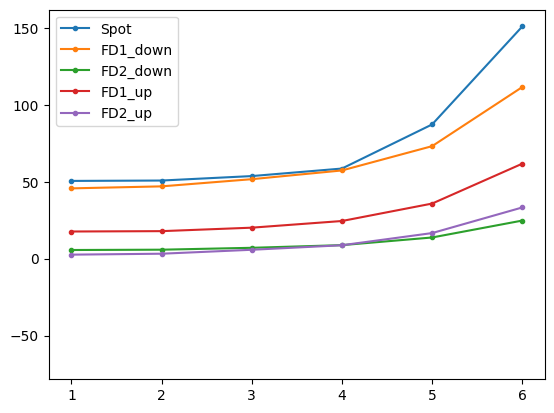

In [22]:
x = np.array(Forecast_number)

# plot for each feature
for f in range(0,F_len-6):
    
    MAE_f = Saved_Info[:,f,1]
    std_f = Saved_Info[:,f,3]
    plt.plot(x, MAE_f, label=F[f], marker='.')
    plt.fill_between(x, MAE_f-std_f, MAE_f-std_f, alpha=0.2)

plt.legend()
plt.show()

## Plot the hourly mean method

# Create a csv file for forecasted values of D-2

In [24]:

N_len = np.size(forecasted_data_3D[:,:,:],2)
F_len = np.size(forecasted_data_3D[:,:,:],0)
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    # change forecasted_data_3D to a dataframe
    df_forecast = pd.DataFrame(forecasted_data_3D[:,:,n], columns=F)
    
    #Create csv
    csv_name_path = path_processed_data+"forecast"+str(Forecast_number[n])+".csv"
    df_forecast.to_csv(csv_name_path,index=False)

# Correlation Analysis

['Spot', 'FD1_down', 'FD2_down', 'FD1_up', 'FD2_up']


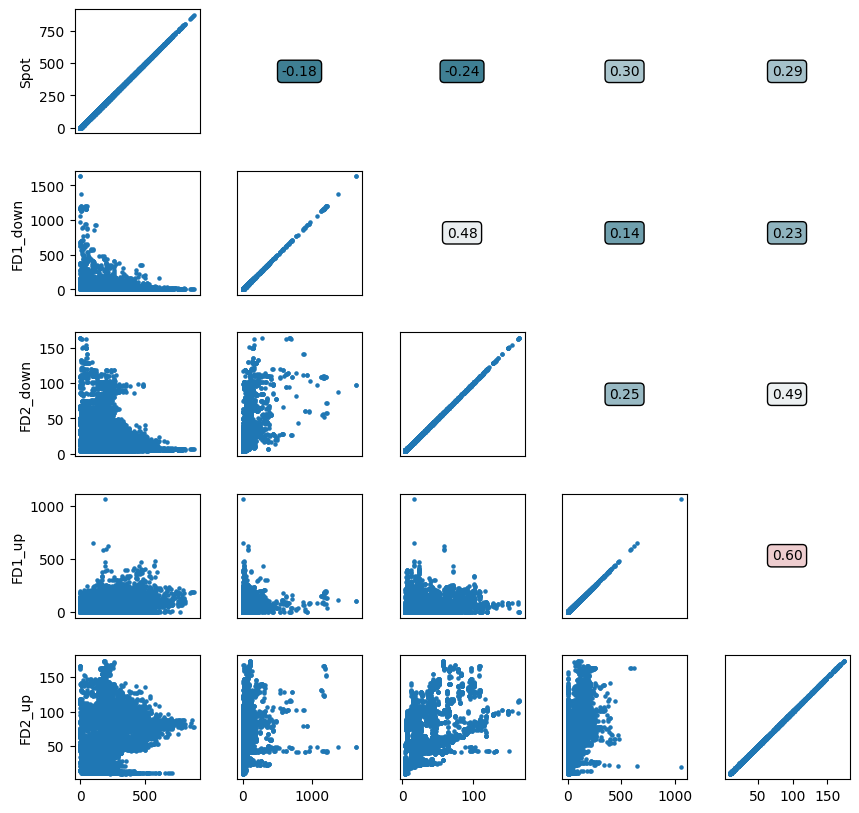

In [5]:
# Create a correlation matrix
corr_data = data[["Spot","FD1_down","FD2_down","FD1_up","FD2_up"]].corr()
# Create a list of column names for the variables in the correlation matrix
cols = corr_data.columns.tolist()
print(cols)

df = data[["Spot","FD1_down","FD2_down","FD1_up","FD2_up"]]
# Create a correlation matrix
corr = corr_data

# Define color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)
M = len(cols) # Number of features

# Create a grid of subplots
fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(10, 10))



# Loop through the rows and columns of the grid
for i in range(M): # through the rows
    for j in range(M): # through the columns
        
        # Plot scatter plot in lower triangle
        if i >= j:
            ax[i, j].scatter(df.iloc[:, j], df.iloc[:, i], s=5)

        # Plot correlation value in upper triangle
        elif i < j:
            corr_val = corr.iloc[i, j]
            ax[i, j].text(0.5, 0.5, f"{corr_val:.2f}", 
                           ha='center', va='center', 
                           transform=ax[i, j].transAxes,
                           bbox=dict(facecolor=cmap(corr_val), edgecolor='black', boxstyle='round'))
            ax[i, j].axis('off')

        if i != M-1: # if row is different from the last one change the x axis
            ax[i, j].xaxis.set_visible(False)
        if j != 0: # if column is different from 0 then change the y axis
            ax[i, j].yaxis.set_visible(False)

        # Set only the axis's for the outer axis
        ax[2, j].set_xlabel(df.columns[j])
        ax[i, 0].set_ylabel(df.columns[i])

# Adjust the layout of the subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the plot
plt.show()

# Non-linear Feature transformation

In [4]:
from sklearn.preprocessing import PolynomialFeatures
transformer = PolynomialFeatures(degree=2, include_bias=False)
cols = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up"]

transformed_data = transformer.fit_transform(data[cols])
transformed_cols = transformer.get_feature_names_out(cols).tolist() # Output it as a list and not numpy array
transformed_df = pd.DataFrame(transformed_data, columns=transformed_cols)
transformed_df.to_csv(path_processed_data + "PolynomialFeatures.csv", sep=',', header=True, index_label='Hour')
print(transformed_df)

            Spot  FD1_down  FD2_down    FD1_up    FD2_up       Spot^2   
0      46.599998  42.42105  33.89313   1.95478  49.18715  2171.559814  \
1      41.330002  42.42105  33.89313   1.95492  49.33709  1708.169065   
2      42.180000  43.36842  33.89313   1.96262  49.71026  1779.152400   
3      44.369999  42.42105  33.89313   1.96222  49.45940  1968.696811   
4      37.669998  41.78947  33.89313   1.95644  49.52272  1419.028749   
...          ...       ...       ...       ...       ...          ...   
10915  92.500000   9.40653  18.32412  27.71766  30.13228  8556.250000   
10916  48.080002   8.94430  18.28115  27.30695  29.82065  2311.686592   
10917  40.930000   9.03942  18.33040  27.34312  29.82881  1675.264900   
10918  35.849998   8.99331  18.35501  27.38835  29.55485  1285.222357   
10919  30.040001   8.95851  18.37732  27.26135  29.58701   902.401660   

       Spot FD1_down  Spot FD2_down  Spot FD1_up  Spot FD2_up   FD1_down^2   
0        1976.820845    1579.419790    91.092